# Predicting the Sale Price of Bulldozers using Machine Learning


## Problem Definition

The goal of the contest is to predict **the sale price** of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  So the question we're trying to answer is :

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## Data  

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), we can see it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) 


## Evaluation 

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.



#### Importing the most cummon EDA libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
#importing training and validating data sets
df = pd.read_csv("data/TrainAndValid.csv", low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

In [7]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

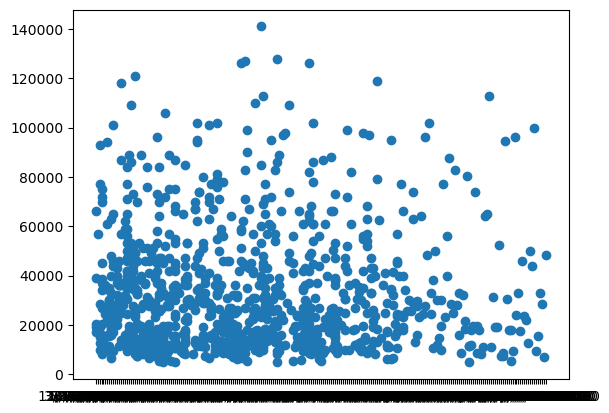

In [8]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000],df['SalePrice'][:1000])

<AxesSubplot:ylabel='Frequency'>

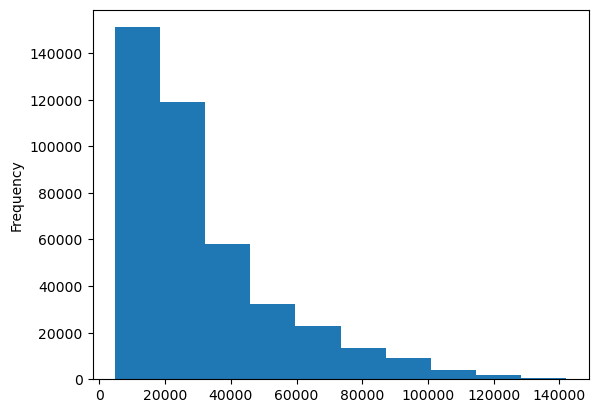

In [9]:
df.SalePrice.plot.hist()

### Parsing dates

So we can enrich our dataset with as much information as possible.

Because we imported the data using `read_csv()` and we asked pandas to parse the dates using `parase_dates=["saledate"]`, we can now access the [different datetime attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html) of the `saledate` column.

In [10]:
df= pd.read_csv('data/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])

In [11]:
df.saledate.dtypes

dtype('<M8[ns]')

In [12]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

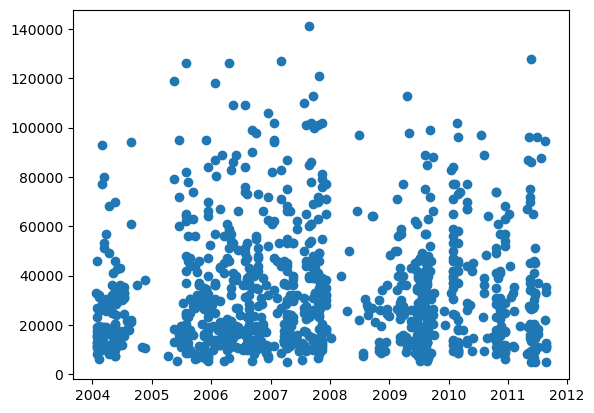

In [13]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

In [14]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [15]:
## sort dataframe by saledate
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [16]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


In [17]:
df_copy=df.copy()

In [18]:
df_copy.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


### Add  datetime parameters for 'saledate' column


In [19]:
df_copy

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
412476,6324811,6000.0,1919104,19330,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411927,6313029,16000.0,1918416,17244,149,99.0,2004,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407124,6266251,55000.0,509560,3357,149,99.0,1993,NaN,NaN,2012-04-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_copy['saleyear']=df_copy.saledate.dt.year
df_copy['salemonth']=df_copy.saledate.dt.month
df_copy['saleday']=df_copy.saledate.dt.day

df_copy['saledayofweek']=df_copy.saledate.dt.dayofweek
df_copy['saledayofyear']=df_copy.saledate.dt.dayofyear

In [21]:
df_copy.T

,205615,274835,141296,212552,62755,54653,81383,204924,135376,113390,...,409202,408976,411695,411319,408889,410879,412476,411927,407124,409203
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,...,6283634,6282337,6311321,6306476,6281219,6302984,6324811,6313029,6266251,6283635
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,...,35000.0,7500.0,13000.0,53000.0,39000.0,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,...,1930870,1928688,1823846,1278794,1792049,1915521,1919104,1918416,509560,1869284
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,...,4701,22072,17311,9114,13976,5266,19330,17244,3357,4701
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984,1976,1986,1970,1987,1966,...,1998,2005,2005,2004,2000,2001,2004,2004,1993,1000
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,...,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00,2012-04-28 00:00:00


In [22]:
df_copy.drop('saledate', axis=1,inplace=True)

In [23]:
df_copy.T

,205615,274835,141296,212552,62755,54653,81383,204924,135376,113390,...,409202,408976,411695,411319,408889,410879,412476,411927,407124,409203
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,...,6283634,6282337,6311321,6306476,6281219,6302984,6324811,6313029,6266251,6283635
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,...,35000.0,7500.0,13000.0,53000.0,39000.0,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,...,1930870,1928688,1823846,1278794,1792049,1915521,1919104,1918416,509560,1869284
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,...,4701,22072,17311,9114,13976,5266,19330,17244,3357,4701
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984,1976,1986,1970,1987,1966,...,1998,2005,2005,2004,2000,2001,2004,2004,1993,1000
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B,D6C,IT12,544,D5HII,12F,...,544H,317,S175,WA320,710VHP,D38E,2064,337G,12G,544H


In [24]:
df_copy.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

## Modelling

In [25]:
## Let's build a machine learning model

In [28]:
from sklearn.ensemble import RandomForestRegressor

model=RandomForestRegressor(n_jobs= -1, random_state=42 )
model.fit(df_copy.drop('SalePrice', axis=1), df_copy.SalePrice)

ValueError: could not convert string to float: 'Low'

In [29]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [30]:
df_copy.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### converting strings to categories
one way we can turn all of our data into numbers is by converting them into pandas categories

In [31]:
pd.api.types.is_string_dtype(df_copy['UsageBand'])


True

In [32]:
#find all columns which contain strings
for label, content in df_copy.items():
    if pd.api.types.is_string_dtype(content) :
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [33]:
# this will turn all of the string value into category value

for label, content in df_copy.items():
    if pd.api.types.is_string_dtype(content) : 
        df_copy[label]=content.astype('category').cat.as_ordered()

In [34]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [35]:
df_copy.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [36]:
df_copy.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [37]:
df_copy.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

In [38]:
# we now have a way to access all of our data in the form of numbers
# however there still some misssing  values

In [39]:
#### save preprocessed data

In [40]:
#export current tmp dataframe
df_copy.to_csv('train_copy.csv', index=False)

In [41]:
df_copy= pd.read_csv('train_copy.csv', low_memory= False)

In [42]:
df_copy.T

,0,1,2,3,4,5,6,7,8,9,...,412688,412689,412690,412691,412692,412693,412694,412695,412696,412697
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,...,6283634,6282337,6311321,6306476,6281219,6302984,6324811,6313029,6266251,6283635
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,...,35000.0,7500.0,13000.0,53000.0,39000.0,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,...,1930870,1928688,1823846,1278794,1792049,1915521,1919104,1918416,509560,1869284
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,...,4701,22072,17311,9114,13976,5266,19330,17244,3357,4701
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984,1976,1986,1970,1987,1966,...,1998,2005,2005,2004,2000,2001,2004,2004,1993,1000
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B,D6C,IT12,544,D5HII,12F,...,544H,317,S175,WA320,710VHP,D38E,2064,337G,12G,544H


In [43]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [44]:
### Filling missing value

In [45]:
#### filling numeric missing values first

In [46]:
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleyear
salemonth
saleday
saledayofweek
saledayofyear


In [47]:
df_copy.ModelID

0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [48]:
# check for which num columns have null values
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [49]:
# fill numeric rows with the median
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            # add a binary column wich tells if the data is missing or not
            df_copy[label+'_is_missing']=pd.isna(content)
            # fill num values with median
            df_copy[label]=content.fillna(content.median())

In [50]:
df_copy.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [51]:
df_copy.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [52]:
df_copy.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

In [53]:
# filling and tunning  cat values into number
for label, content in df_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)


UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [54]:
pd.Categorical(df_copy['state']).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [55]:
for label, content in df_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        # add a binary column wich tells if the data is missing or not
            df_copy[label+'_is_missing']=pd.isna(content)
            #turn cat in numbers and add 1
            df_copy[label]=pd.Categorical(content).codes+1

In [56]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [57]:
df_copy.T

,0,1,2,3,4,5,6,7,8,9,...,412688,412689,412690,412691,412692,412693,412694,412695,412696,412697
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,...,6283634,6282337,6311321,6306476,6281219,6302984,6324811,6313029,6266251,6283635
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,...,35000.0,7500.0,13000.0,53000.0,39000.0,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,...,1930870,1928688,1823846,1278794,1792049,1915521,1919104,1918416,509560,1869284
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,...,4701,22072,17311,9114,13976,5266,19330,17244,3357,4701
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False,False,True,True,False,True,...,True,True,True,True,True,False,True,True,True,True
Blade_Type_is_missing,False,True,False,True,False,False,True,True,False,True,...,True,True,True,True,True,False,True,True,True,True
Travel_Controls_is_missing,False,True,False,True,False,False,True,True,False,True,...,True,True,True,True,True,False,True,True,True,True
Differential_Type_is_missing,True,False,True,False,True,True,False,False,True,True,...,False,True,True,False,True,True,True,True,True,False


In [58]:
df_copy.T.head(60)

,0,1,2,3,4,5,6,7,8,9,...,412688,412689,412690,412691,412692,412693,412694,412695,412696,412697
SalesID,1646770,1821514,1505138,1671174,1329056,1301884,1379228,1645390,1493279,1449549,...,6283634,6282337,6311321,6306476,6281219,6302984,6324811,6313029,6266251,6283635
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0,23500.0,31000.0,11750.0,63000.0,13000.0,...,35000.0,7500.0,13000.0,53000.0,39000.0,16000.0,6000.0,16000.0,55000.0,34000.0
MachineID,1126363,1194089,1473654,1327630,1336053,1182999,1082797,1527216,1363756,1289412,...,1930870,1928688,1823846,1278794,1792049,1915521,1919104,1918416,509560,1869284
ModelID,8434,10150,4139,8591,4089,4123,7620,8202,2759,3356,...,4701,22072,17311,9114,13976,5266,19330,17244,3357,4701
datasource,132,132,132,132,132,132,132,132,132,132,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,18.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,...,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984,1976,1986,1970,1987,1966,...,1998,2005,2005,2004,2000,2001,2004,2004,1993,1000
MachineHoursCurrentMeter,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UsageBand,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fiModelDesc,4593,1820,2348,1819,2119,2298,3126,979,2224,82,...,989,536,4261,4818,1319,2101,240,627,83,989


In [59]:
df_copy.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

## Fitting a machine learning model

In [60]:
len(df_copy)

412698

In [61]:
%%time

model=RandomForestRegressor(n_jobs= -1, random_state=42 )
model.fit(df_copy.drop('SalePrice', axis=1), df_copy.SalePrice)

Wall time: 5min 49s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [62]:
model.score(df_copy.drop('SalePrice', axis=1), df_copy.SalePrice)

0.9875468079970562

### splitting data into train/validation sets

In [63]:
df_copy.saleyear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleyear, dtype: int64

In [64]:
df_val=df_copy[df_copy.saleyear == 2012]
df_train=df_copy[df_copy.saleyear!= 2012]
len(df_train),len(df_val)

(401125, 11573)

In [65]:
#split data into x and y
x_train, y_train= df_train.drop('SalePrice', axis=1), df_train.SalePrice

In [66]:
x_valid, y_valid=df_val.drop('SalePrice', axis=1), df_val.SalePrice

In [67]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((401125, 102), (11573, 102), (401125,), (11573,))

# Evaluation

In [68]:
from sklearn.metrics import  mean_squared_log_error, mean_absolute_error 

# evaluation fonction

def rmsle(y_test, y_preds):
    """
    calculate root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

In [69]:
#evalution function of the model on different level
def show_scores(model):
    train_preds = model.predict(x_train)
    val_preds = model.predict(x_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R2": model.score(x_train, y_train),
              "Valid R2": model.score(x_valid, y_valid)}
    return scores

### Testing the model on a subset (to tune parameters)

In [70]:
#this takes far too long.. for experimenting 
#model =RandomForestRegressor(n_jobs=-1, random_state=42)
#model.fit(x_train, y_train)

In [71]:
model.fit(x_train[:1000], y_train[:1000])

RandomForestRegressor(n_jobs=-1, random_state=42)

In [72]:
# change max simples value
model = RandomForestRegressor(n_jobs=-1, max_samples=10000)


Setting `max_samples` to 10000 means every `n_estimator` (default 100) in our `RandomForestRegressor` will only see 10000 random samples from our DataFrame instead of the entire 400,000.

In other words, we'll be looking at 40x less samples which means we'll get faster computation speeds but we should expect our results to worsen (simple the model has less samples to learn patterns from).

In [73]:
%time
#cutting down on the max number of smples each estimator can see improves trainning time
model.fit(x_train, y_train)


Wall time: 0 ns


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [74]:
show_scores(model)

{'Training MAE': 5566.141516459955,
 'Valid MAE': 7158.4982148103345,
 'Training RMSLE': 0.25756148805419204,
 'Valid RMSLE': 0.29294029585637804,
 'Training R2': 0.8600546810544458,
 'Valid R2': 0.8320281987984223}

## Hyperparameter tuning with RandomizedSearchCV

In [75]:
%%time
from sklearn.model_selection import RandomizedSearchCV

#RandomForestRegressor hyperparameters to test
rf_grid={"n_estimators": np.arange(10,100,10),
        "max_depth":[None, 3,5,10],
        "min_samples_split": np.arange(2,20,2),
        "min_samples_leaf": np.arange(1, 20, 2),
        "max_features": [0.5, 1, "sqrt", "auto"],
        "max_samples": [10000]}

#Instantiate RandomzedSearchCV
rs_model= RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                              param_distributions= rf_grid,
                              n_iter=5,
                              cv=5,
                              verbose=True)

#fit the RandomizedSearchCV model
rs_model.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Wall time: 2min 50s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [76]:
#the best model hyperparameters
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 14,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [77]:
#evaluation of the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 5864.976843477837,
 'Valid MAE': 7395.086677950414,
 'Training RMSLE': 0.2676422685357981,
 'Valid RMSLE': 0.29829912535860253,
 'Training R2': 0.8432887068038701,
 'Valid R2': 0.8160870971892027}

### Train the model with the best hyperparameters

I tried 100 different combinations of hyperparameters (setting `n_iter` to 100 in `RandomizedSearchCV`) and found the best results came from the ones you see below.

**Note:** This  search on my DELL INSPIRON 13 computer (`n_iter` = 100) took ~3-hours. So it's a set and come back later experiment.

We'll instantiate a new model with these discovered hyperparameters and reset the `max_samples` back to its original value.

In [78]:
%%time
rs_model= RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                              param_distributions= rf_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

#fit the RandomizedSearchCV model
rs_model.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [79]:
#the best model hyperparameters
rs_model.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [80]:
%%time
# Most ideal hyperparameters that I found for the model
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)
ideal_model.fit(x_train, y_train)

Wall time: 2min 52s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=90,
                      n_jobs=-1)

In [81]:
show_scores(ideal_model)

{'Training MAE': 2924.707807798699,
 'Valid MAE': 5904.76428111114,
 'Training RMSLE': 0.14319859841653085,
 'Valid RMSLE': 0.2439452280632985,
 'Training R2': 0.9597501801684463,
 'Valid R2': 0.8834669924291724}

## Make prediction on test data

In [82]:
#import the test data

df_test= pd.read_csv("data/Test.csv",
                    low_memory=False,
                    parse_dates=["saledate"])
df_test.T.head(80)

,0,1,2,3,4,5,6,7,8,9,...,12447,12448,12449,12450,12451,12452,12453,12454,12455,12456
SalesID,1227829,1227844,1227847,1227848,1227863,1227870,1227871,1227879,1227880,1227881,...,6643158,6643164,6643167,6643168,6643170,6643171,6643173,6643184,6643186,6643196
MachineID,1006309,1022817,1031560,56204,1053887,1068694,1012262,1064696,1067175,1007429,...,2556488,1894070,2558314,2558315,2558316,2558317,2558332,2558342,2558343,2558346
ModelID,3168,7271,22805,1269,22312,16747,9133,4699,22145,423,...,21434,21438,21450,21450,21450,21450,21434,21437,21437,21446
datasource,121,121,121,121,121,121,121,121,121,121,...,149,149,149,149,149,149,149,149,149,149
auctioneerID,3,3,3,3,3,3,3,3,3,3,...,99,99,2,2,2,2,2,2,2,2
YearMade,1999,1000,2004,2006,2005,2007,2005,1000,1000,2000,...,2004,2005,2005,2005,2006,2008,2005,1000,2006,2008
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0,3670.0,6759.0,0.0,5528.0,10572.0,...,NaN,2233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UsageBand,Low,High,Medium,High,Low,High,High,NaN,Low,Medium,...,NaN,Low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,2012-05-03 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-03 00:00:00,2012-05-03 00:00:00,2012-05-03 00:00:00,2012-05-03 00:00:00,2012-05-03 00:00:00,...,2012-10-13 00:00:00,2012-10-27 00:00:00,2012-10-24 00:00:00,2012-10-24 00:00:00,2012-10-24 00:00:00,2012-10-24 00:00:00,2012-10-24 00:00:00,2012-10-24 00:00:00,2012-10-24 00:00:00,2012-09-19 00:00:00
fiModelDesc,580G,936,EC210BLC,330CL,650K,WB146-5,WB140,544E,650GIV,PC228USLC2,...,28N,35NX,80NX3,80NX3,80NX3,80NX3,28N,35N,35N,55N2


In [83]:
#make predictions on test data set
test_preds= ideal_model.predict(df_test)

C:\Users\annou\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Low'

In [84]:
df_test.info(), df_test.isna().sum(), df_test.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

(None,
 SalesID                         0
 MachineID                       0
 ModelID                         0
 datasource                      0
 auctioneerID                    0
 YearMade                        0
 MachineHoursCurrentMeter    10328
 UsageBand                   10623
 saledate                        0
 fiModelDesc                     0
 fiBaseModel                     0
 fiSecondaryDesc              3975
 fiModelSeries               10451
 fiModelDescriptor            9433
 ProductSize                  6409
 fiProductClassDesc              0
 state                           0
 ProductGroup                    0
 ProductGroupDesc                0
 Drive_System                 9698
 Enclosure                       2
 Forks                        6149
 Pad_Type                    10349
 Ride_Control                 8216
 Stick                       10349
 Transmission                 7639
 Turbocharged                10349
 Blade_Extension             11806
 Blade_Width 

In [85]:
x_train.shape

(401125, 102)

## Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [86]:
def preprocess_data(df):
    """
    perform transformations on df and returns transformed df
    """
    df['saleyear']=df.saledate.dt.year
    df['salemonth']=df.saledate.dt.month
    df['saleday']=df.saledate.dt.day

    df['saledayofweek']=df.saledate.dt.dayofweek
    df['saledayofyear']=df.saledate.dt.dayofyear
    df.drop("saledate", axis=1, inplace=True)
    
    #filling the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isna(content).sum():
                # add a binary column wich tells if the data is missing or not
                df[label+'_is_missing']=pd.isna(content)
                # fill num values with median
                df[label]=content.fillna(content.median())
    
        #filling categorical missing data and turn cat data into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"]=pd.isnull(content)
            # add +1 to the category code because pandas encodes missing categories with -1
            df[label]=pd.Categorical(content).codes+1

        
    return df

In [87]:
# preprocess the test data
df_test=preprocess_data(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Columns: 101 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(45), float64(1), int16(2), int64(11), int8(42)
memory usage: 2.2 MB


In [88]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [89]:
#make prediction
test_preds= ideal_model.predict(df_test)

C:\Users\annou\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- auctioneerID_is_missing

  warnings.warn(message, FutureWarning)


ValueError: X has 101 features, but RandomForestRegressor is expecting 102 features as input.

In [90]:
x_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
1,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
2,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
3,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
4,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [91]:
# we can find how the columns differ using sets
set(x_train.columns)-set(df_test.columns)

{'auctioneerID_is_missing'}

In [92]:
# adjust df_test to have auctioneerID_is_missing column
df_test['auctioneerID_is_missing']=False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Now our test dataframe has the same features as our training dataframe, we can make predictions ^^

In [93]:
#making predictions on the data set
test_preds= ideal_model.predict(df_test)

C:\Users\annou\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [94]:
test_preds

array([19948.03214658, 21883.39443276, 51792.63734302, ...,
       13449.6509849 , 19812.35079067, 28314.39567974])

When looking at the [Kaggle submission requirements](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation), we see that if we wanted to make a submission, the data is required to be in a certain format. Namely, a DataFrame containing the `SalesID` and the predicted `SalePrice` of the bulldozer.

In [95]:
#turn prediction into the same format kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,19948.032147
1,1227844,21883.394433
2,1227847,51792.637343
3,1227848,64787.730056
4,1227863,45131.599203
...,...,...
12452,6643171,43882.531160
12453,6643173,15510.141852
12454,6643184,13449.650985
12455,6643186,19812.350791


In [96]:
#export prediction data
df_preds.to_csv("test_predictions.csv")

## Feature Importance

After our model learned the patterns in the data, which bulldozer sale attributes were most important for predicting its overall sale price?

we shold be aware that the default feature importances for random forests can lead to non-ideal results.

Let's find the `feature_importances_` attribute of our `RandomForestRegressor` model.

In [105]:
ideal_model.feature_importances_

array([3.37576912e-02, 2.17651434e-02, 4.02755514e-02, 1.77134908e-03,
       3.33961911e-03, 2.05700407e-01, 3.25695662e-03, 1.03151619e-03,
       4.50263443e-02, 5.15132182e-02, 6.75583896e-02, 4.79572275e-03,
       2.19791103e-02, 1.55529998e-01, 4.55063627e-02, 5.91374598e-03,
       2.38856757e-03, 3.38556769e-03, 3.54763227e-03, 5.18052665e-02,
       4.59088056e-04, 2.07417342e-04, 1.32809470e-03, 1.71788581e-04,
       1.21471473e-03, 2.26561630e-05, 1.01925735e-03, 2.47734895e-03,
       5.33844361e-04, 9.77146645e-04, 3.82626036e-03, 3.74293137e-03,
       3.31791601e-03, 1.06327571e-03, 2.59827499e-04, 1.12558495e-02,
       8.86608522e-04, 1.38971510e-02, 1.14845641e-03, 3.59173648e-03,
       1.07534342e-03, 8.52652805e-04, 1.41146420e-03, 5.83459190e-04,
       5.92600111e-04, 3.55258830e-04, 2.94267385e-04, 2.12696809e-03,
       9.62830436e-04, 2.36323781e-04, 4.90424976e-04, 7.36578482e-02,
       3.83895940e-03, 5.65293773e-03, 2.90590469e-03, 9.85855926e-03,
      

In [102]:
# plotting feature importance
def plot_features(columns, importances, n=20):
    df= (pd.DataFrame({"feature": columns, 
                     "feature_importance": importances})
    .sort_values("feature_importance", ascending=False)
    .reset_index(drop=True))
    #ploting the data frame
    fig, ax= plt.subplots(figsize=(8,8))
    ax.barh(df["feature"][:n], df["feature_importance"][:n])
    ax.set(xlabel="features",
          ylabel="feature_importance")

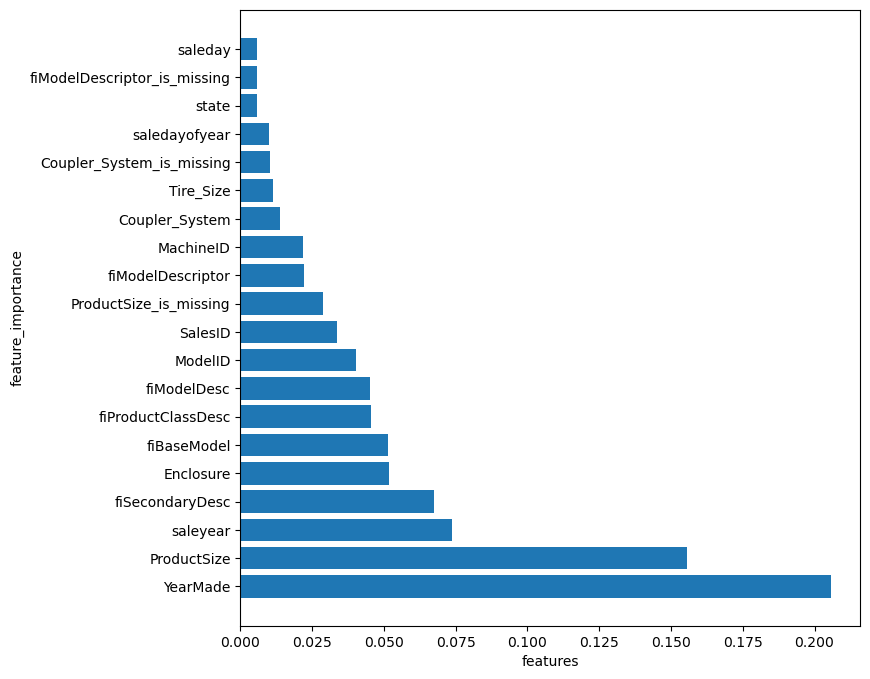

In [103]:
plot_features(x_train.columns,ideal_model.feature_importances_)

In [106]:
sum(ideal_model.feature_importances_)

0.9999999999999996